In [100]:
import requests
from bs4 import BeautifulSoup
import datetime
import pandas as pd
from tqdm import tqdm
import regex as re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [87]:
### read tables from pkl
with open('/Users/euan_brown/Documents/GitHub/NCAA-fh-project/tables.pkl', 'rb') as f:
    data = pickle.load(f)

schedule_table, pbp_table, box_table, player_table = data[0], data[1], data[2], data[3]


In [92]:
box_table[box_table.player_name.str.contains('Kness, Emily')];

In [93]:
box_table[box_table.player_name.str.contains('Sessa, Ashley')];

In [95]:
player_table[player_table.team_name=='North Carolina'];

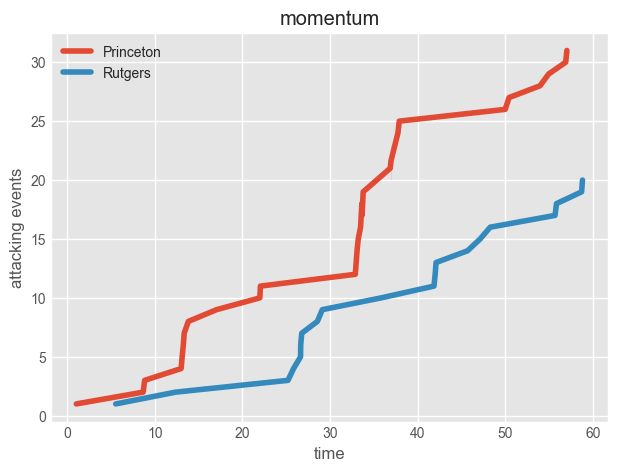

In [96]:
plt.style.use('ggplot')

plot_data = pbp_table[pbp_table['game_ID']==202]
plot_data = plot_data[plot_data['cat_event'].isin(['shot','corner','goal'])]
plot_data = plot_data[['time','home_team_name','away_team_name','home_score','away_score','cat_event','event_team']]
plot_data['pts'] = 1


plot_data_home = plot_data[plot_data['event_team']=='home']
plot_data_away = plot_data[plot_data['event_team']=='away']
plot_data_home['cumsum_pts'] = plot_data_home.pts.cumsum()
plot_data_away['cumsum_pts'] = plot_data_away.pts.cumsum()


fig, ax = plt.subplots()

sns.lineplot(x='time', y='cumsum_pts', data=plot_data_home, ax=ax, label=plot_data_home.home_team_name.unique()[0])
sns.lineplot(x='time', y='cumsum_pts', data=plot_data_away, ax=ax, label=plot_data_away.away_team_name.unique()[0])

ax.set_xlabel('time')
ax.set_ylabel('attacking events')
ax.set_title('momentum')
ax.legend()

plt.show()

In [97]:
# momentum code - very useful

plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
plot_data['momentum'] = (np.where(plot_data['event_team']=='home',plot_data['pts'],0) - np.where(plot_data['event_team']=='away',plot_data['pts'],0)).cumsum()

In [102]:

def momentumplot(target):

    plt.style.use('seaborn-v0_8-bright')
    
    
    for ID in pbp_table[pbp_table['home_team_name']==target]['game_ID'].unique().tolist() + pbp_table[pbp_table['away_team_name']==target]['game_ID'].unique().tolist():
    
      plot_data = pbp_table[pbp_table['game_ID']==ID]
      plot_data = plot_data[plot_data['cat_event'].isin(['shot','corner','goal'])]
      plot_data = plot_data[['time','home_team_name','away_team_name','home_score','away_score','cat_event','event_team']]
      plot_data['pts'] = 1
    
    
      if str(plot_data.home_team_name.unique()[0]) == target :
        val = 0
        plot_data_home = plot_data[plot_data['event_team']=='home']
        plot_data_away = plot_data[plot_data['event_team']=='away']
        
        t1 = str(plot_data.home_team_name.unique()[0])
        t2 = str(plot_data.away_team_name.unique()[0])
        
        plot_data_home['cumsum_pts'] = plot_data_home.pts.cumsum()
        plot_data_away['cumsum_pts'] = plot_data_away.pts.cumsum()
    
        plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
        plot_data['momentum'] = (np.where(plot_data['event_team']=='home',plot_data['pts'],0) - np.where(plot_data['event_team']=='away',plot_data['pts'],0)).cumsum()
    
      if str(plot_data.home_team_name.unique()[0]) != target :
        val = 1
        plot_data_home = plot_data[plot_data['event_team']=='away']
        plot_data_away = plot_data[plot_data['event_team']=='home']
        
        t1 = str(plot_data.away_team_name.unique()[0])
        t2 = str(plot_data.home_team_name.unique()[0])
        
        plot_data_home['cumsum_pts'] = plot_data_away.pts.cumsum()
        plot_data_away['cumsum_pts'] = plot_data_home.pts.cumsum()
    
        plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
        plot_data['momentum'] = (np.where(plot_data['event_team']=='away',plot_data['pts'],0) - np.where(plot_data['event_team']=='home',plot_data['pts'],0)).cumsum()
      fig, ax = plt.subplots()
    
      if plot_data.momentum.max() < 2:
        ax.set_ylim(plot_data.momentum.min()-1,4)
    
      if plot_data.momentum.min() > -2:
        ax.set_ylim(-4,plot_data.momentum.max()+1)
    
    
      ax.axhline(0, color='black', linestyle='--')
      
      if val == 0:
        for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'away')]['time']:
          ax.axvline(value, color='red', linestyle='--')
    
        for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'home')]['time']:
          ax.axvline(value, color='green', linestyle='--')
    
      if val == 1:
        for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'away')]['time']:
          ax.axvline(value, color='green', linestyle='--')
    
        for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'home')]['time']:
          ax.axvline(value, color='red', linestyle='--')
    
    
      sns.lineplot(x='time', y='momentum', data = plot_data, ax=ax,color='grey')
    
      ax.annotate(t1,(15,1))
      ax.annotate(t2,(15,-1))
    
      ax.set_xlabel('minutes')
      ax.set_ylabel('momentum')
      #ax.yaxis.set_tick_params(labelleft=False)
      
      custom_lines = [Line2D([0], [0], color='green', lw=4), Line2D([0], [0], color='red', lw=4)]
      
      
      ax.legend(custom_lines,['goal for','goal against'],bbox_to_anchor=(1.1, 1.1),loc = 'lower right')
      plt.tight_layout()
      clear_output(wait=True)
    
      directory = f'/Users/euan_brown/Desktop/Python output/{t1}/'
    
      if not os.path.exists(directory):
        os.makedirs(directory)
    
      plt.savefig(f'/Users/euan_brown/Desktop/Python output/{t1}/{t1}_{t2}_momentumchart.png',format='png')
      plt.show()

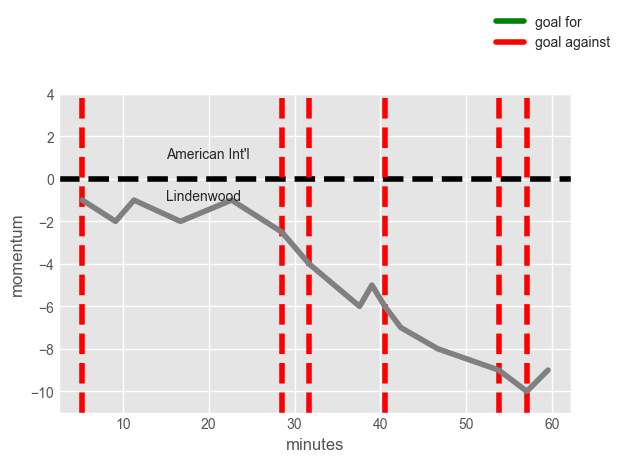

In [140]:
for target in schedule_table.team_name.unique():
    momentumplot(target)

In [138]:
### stuck hear with names etc

# maybe where this project ends?

# momentum was cool

# lots of other potential, shot outcome wasnt really looked at

# kicking back could be looked at

# momentum pattern classification?

# could this be applies to other sports? basketball might have done this already?

pbp_table[pbp_table.events.str.contains('For')]['events'].tolist()[10].split(':')[1].lower().strip()#.split(', ')

"jardell, monique, davies, georgia, riccardo, celina, wheatley, ellie, fulton, lulu, o'neill, emma, jarvie, hannah, rutherford, ellie, hanssen, merel, burns, gracie, harlock, ashley"

In [117]:
pbp_table[pbp_table.events.str.contains('substitution')]['events'].tolist()

["DREXEL substitution: Cailey Lever for Bri O'Donnell.",
 'DREXEL substitution: Emily Owens for Amber Brouwer.',
 'DREXEL substitution: Puk Thewessen for Isabel Jacobs.',
 'DREXEL substitution: Shannon Tringola for Avery Powell.',
 'UMD substitution: Belle Bressler for Margot Lawn.',
 'UMD substitution: Sam Zywna for Sophie Klautz.',
 'UMD substitution: Ericka Morris-Adams for Nathalie Fiechter.',
 'UMD substitution: Kylee Niswonger for Bibi Donraadt.',
 'DREXEL substitution: Amber Brouwer for Cailey Lever.',
 'DREXEL substitution: Isabel Jacobs for Tina Rawa.',
 'UMD substitution: Bibi Donraadt for Emma DeBerdine.',
 'UMD substitution: Sophie Klautz for Sam Zywna.',
 'UMD substitution: Margot Lawn for Hope Rose.',
 'DREXEL substitution: Eline Di Leva for Emily Owens.',
 'DREXEL substitution: Tina Rawa for Puk Thewessen.',
 'UMD substitution: Hope Rose for Belle Bressler.',
 'UMD substitution: Emma DeBerdine for Leah Crouse.',
 "DREXEL substitution: Cailey Lever for Bri O'Donnell.",
 '